In [1]:
import warnings
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'skyblue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'indianred')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Regresión lineal Examen

In [4]:
# De rendimiento actual
data['Hits_per_AtBat'] = data['Hits'] / data['AtBat']
data['HmRun_per_Hits'] = data['HmRun'] / data['Hits']
data['RBIs_per_Hits'] = data['RBI'] / data['Hits']
data['Runs_per_Hits'] = data['Runs'] / data['Hits']

# De rendimiento histórico
data['CHits_per_CAtBat'] = data['CHits'] / data['CAtBat']
data['CHmRun_per_CHits'] = data['CHmRun'] / data['CHits']
data['CRuns_per_CHits'] = data['CRuns'] / data['CHits']
data['Years_AvgHits'] = data['CHits'] / data['Years']

# Transformaciones
data['log_CRuns'] = np.log(data['CRuns']+1)
data['sqrt_CHits'] = np.sqrt(data['CHits']+1)

In [5]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.4f}')

R2: 0.7134


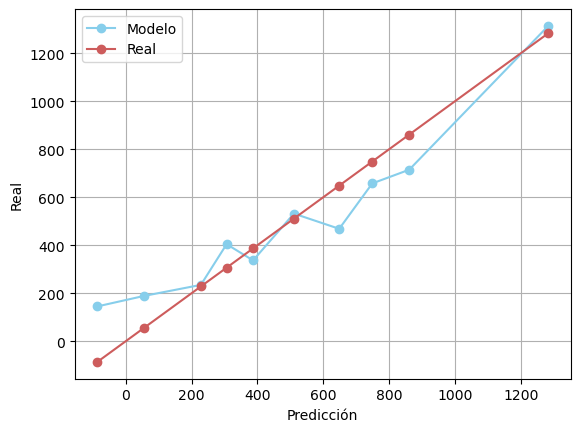

In [8]:
calibracion(y_pred, y_test, 10)

El r2 obtenido con la regresión lineal es de 0.7134, lo que significa que se explica el 71.34% de la variación de los datos, siendo así un buen modelo. Este fue el mejor modelo obtenido en el examen, posteriormente haremos una regresión con una red neuronal para ver los resultados.

## Red Neuronal

In [9]:
# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor())
])
# Params grid
params_grid = {
    'nn__hidden_layer_sizes': [(50,25,50), (128,64,32), (100,50,100), (10,10,10)],
    'nn__activation': ['tanh', 'relu', 'logistic'],
    'nn__alpha': [0.1, 0.01, 0.001]
}
# Fit model
grid_nn = GridSearchCV(estimator=pipeline, param_grid=params_grid, n_jobs=-1, cv=5, scoring='r2')
grid_nn.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nn', MLPRegressor())]),
             n_jobs=-1,
             param_grid={'nn__activation': ['tanh', 'relu', 'logistic'],
                         'nn__alpha': [0.1, 0.01, 0.001],
                         'nn__hidden_layer_sizes': [(50, 25, 50), (128, 64, 32),
                                                    (100, 50, 100),
                                                    (10, 10, 10)]},
             scoring='r2')

In [10]:
grid_nn.best_params_

{'nn__activation': 'relu',
 'nn__alpha': 0.01,
 'nn__hidden_layer_sizes': (128, 64, 32)}

In [11]:
# Calcular R2
pred_nn = grid_nn.best_estimator_.predict(X_test)
print(f'R2: {r2_score(y_test, pred_nn):.4f}')

R2: 0.4460


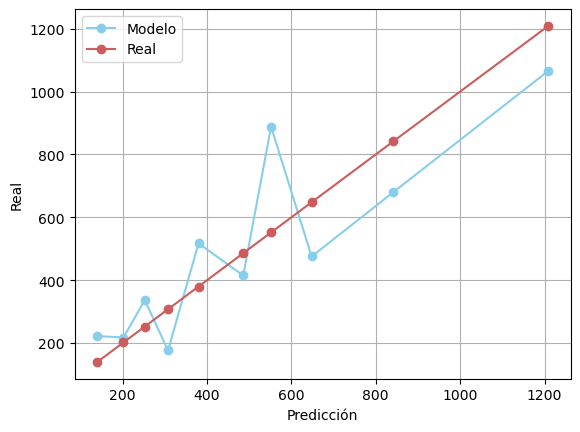

In [12]:
calibracion(pred_nn, y_test, 10)

Utilizando la red neuronal a través de `GridSearch` para probar todos los parámetros, el mejor resultado fue con la función de activación `relu` usando 3 capas con 128, 64 y 32 neuronas respectivamente, obteniendo un r2 de 0.4460, por lo que el modelo tuvo un rendimiento mucho menor al de la regresión lineal, por lo que aumentar la complejidad de un modelo no significa que será mejor. 

Además como se aprecia en la gráfica de calibración, existen errores muy grandes en la parte media y baja de salarios, haciendo que el modelo no sea bueno prediciendo. Por lo que el uso de una red neuronal para esta tarea de predicción no fue de ayuda y modelos más simples como la regresión lineal son efectivos.